# Set up Data

# Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
from PIL import Image
import cv2
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Input,Conv2DTranspose,Dropout,BatchNormalization,Activation,concatenate
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report,roc_curve, auc
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import shutil
from sklearn.model_selection import train_test_split
import random
from pathlib import Path

2025-08-15 15:53:10.848735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755273191.217242      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755273191.323163      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Explore the Data

In [2]:
base_dir = '/kaggle/input/shop-data/Shop DataSet'
classes = ['non shop lifters', 'shop lifters']
HEIGHT, WIDTH = 224, 224
NUM_CLASSES = 1  # Binary classification (0 = no theft, 1 = theft)
n_frames = 10                # How many frames to extract per video
frame_step = 15              # How many frames to skip between selected frames
output_size = (224, 224)     # Resize all frames to this size
batch_size = 8               # Number of videos per training batch

In [3]:
print('non shop lifters : ',len(os.listdir(base_dir+'/non shop lifters')))
print('shop lifters : ',len(os.listdir(base_dir+'/shop lifters')))

non shop lifters :  531
shop lifters :  324


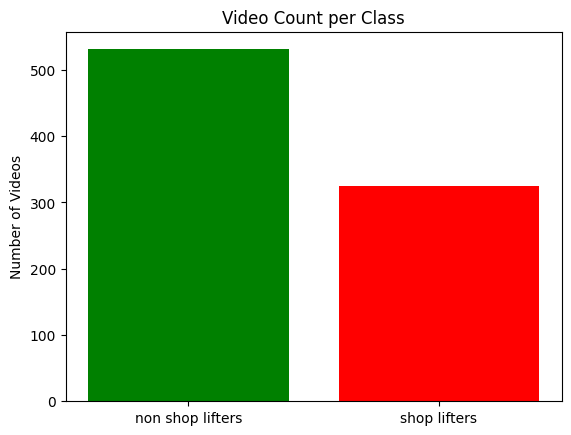

In [4]:
video_counts = []
labels = []

for cls in classes:
    class_path = os.path.join(base_dir, cls)
    count = len([f for f in os.listdir(class_path) if f.endswith('.mp4')])
    video_counts.append(count)
    labels.append(cls)

plt.bar(labels, video_counts, color=['green', 'red'])
plt.title("Video Count per Class")
plt.ylabel("Number of Videos")
plt.show()


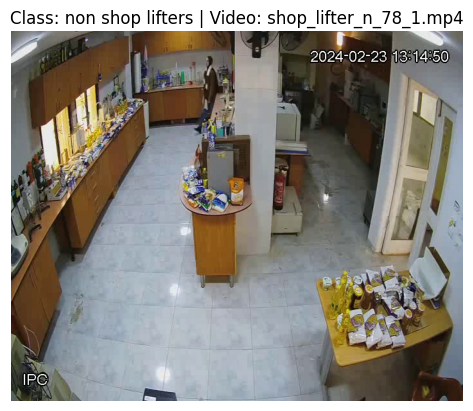

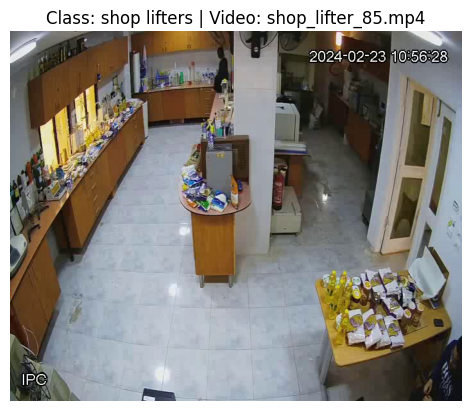

In [5]:
def show_random_video_frame(class_name):
    class_path = os.path.join(base_dir, class_name)
    videos = [f for f in os.listdir(class_path) if f.endswith('.mp4')]

    if not videos:
        print("No videos found.")
        return

    selected_video = random.choice(videos)
    video_path = os.path.join(class_path, selected_video)

    # Read first frame
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title(f"Class: {class_name} | Video: {selected_video}")
        plt.axis('off')
        plt.show()
    else:
        print("Failed to read frame from video.")

# Show one sample from each class
for cls in classes:
    show_random_video_frame(cls)


# Data Generator

In [6]:
def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

def frames_from_video_file(video_path, n_frames, output_size=(224,224), frame_step=15, start_frame=0):
    """Extract a sequence of frames starting from start_frame."""
    result = []
    src = cv2.VideoCapture(str(video_path))
    src.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    for _ in range(n_frames):
        ret, frame = src.read()
        if ret:
            result.append(format_frames(frame, output_size))
            for _ in range(frame_step - 1):
                src.read()  # skip frames
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    return result

def multiple_clips_from_video(video_path, n_frames, frame_step, output_size, clips_per_video=3):
    """Extract multiple clips from different parts of the video."""
    src = cv2.VideoCapture(str(video_path))
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    src.release()

    clip_length = 1 + (n_frames - 1) * frame_step
    possible_starts = max(1, video_length - clip_length)

    clips = []
    for _ in range(clips_per_video):
        start_frame = random.randint(0, possible_starts)
        clip = frames_from_video_file(video_path, n_frames, output_size, frame_step, start_frame)
        clips.append(clip)

    return clips


In [7]:
class FrameGenerator:
    def __init__(self, path, n_frames, frame_step=10, shuffle=False, deterministic=False):
        self.path = path
        self.n_frames = n_frames
        self.frame_step = frame_step  # <-- store it here
        self.shuffle = shuffle
        self.deterministic = deterministic
        self.class_names = sorted([p.name for p in self.path.iterdir() if p.is_dir()])
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob("*/*.mp4"))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))
        if self.shuffle:
            random.shuffle(pairs)

        for path, class_name in pairs:
            label = self.class_ids_for_name[class_name]
            src = cv2.VideoCapture(str(path))
            video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
            src.release()

            clip_length = 1 + (self.n_frames - 1) * self.frame_step
            stride = clip_length  # non-overlapping

            starts = list(range(0, max(1, video_length - clip_length + 1), stride))
            if self.shuffle and not self.deterministic:
                random.shuffle(starts)

            for start_frame in starts:
                video_frames = frames_from_video_file(
                    path,
                    self.n_frames,
                    frame_step=self.frame_step,
                    start_frame=start_frame
                )
                yield video_frames, label


In [8]:
# ------------------ Dataset Split ------------------
# We'll manually split data into train/val/test folders

def prepare_split(source_dir, split_dir, splits=(0.7, 0.2, 0.1)):
    """
    Split dataset into train/val/test ensuring that all clips from the same video
    go to the same split.
    """
    import shutil
    import random
    import re
    from pathlib import Path

    # If split dir exists, delete it so we can recreate
    if split_dir.exists():
        shutil.rmtree(split_dir)
    split_dir.mkdir(parents=True, exist_ok=True)

    # Group videos by base name
    grouped_videos = {}
    for class_dir in source_dir.iterdir():
        if class_dir.is_dir():
            for v in class_dir.glob("*.mp4"):
                base_name = re.sub(r'_part\d+', '', v.stem)
                grouped_videos.setdefault((class_dir.name, base_name), []).append(v)

    # Shuffle groups
    groups = list(grouped_videos.items())
    random.shuffle(groups)

    # Compute split indices
    n = len(groups)
    train_end = int(n * splits[0])
    val_end = train_end + int(n * splits[1])

    split_names = ['train', 'val', 'test']
    split_ranges = [groups[:train_end], groups[train_end:val_end], groups[val_end:]]

    # Copy videos
    for split_name, group_list in zip(split_names, split_ranges):
        for (class_name, _), videos in group_list:
            split_class_dir = split_dir / split_name / class_name
            split_class_dir.mkdir(parents=True, exist_ok=True)
            for v in videos:
                target = split_class_dir / v.name
                shutil.copy(v, target)


In [9]:
# Prepare data
split_root = Path("/kaggle/working/Shop_DataSet_split")
prepare_split(Path(base_dir), split_root)

# Create datasets
frame_shape = (n_frames, 224, 224, 3)

# Create datasets
train_ds = tf.data.Dataset.from_generator(
    FrameGenerator(split_root / 'train', n_frames, shuffle=True),
    output_signature=(
        tf.TensorSpec(shape=frame_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

val_ds = tf.data.Dataset.from_generator(
    FrameGenerator(split_root / 'val', n_frames),
    output_signature=(
        tf.TensorSpec(shape=frame_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

test_ds = tf.data.Dataset.from_generator(
    FrameGenerator(split_root / 'test', n_frames),
    output_signature=(
        tf.TensorSpec(shape=frame_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

I0000 00:00:1755273243.339193      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755273243.339942      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
# Batch
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [11]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [12]:
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

In [13]:
videos,labels = next(iter(train_ds))
print(f'videos: {videos.shape}')
print(f'labels: {labels.shape}')
print(f'labels: {labels}')

videos: (8, 10, 224, 224, 3)
labels: (8,)
labels: [1 1 1 0 0 1 1 1]


# **Modeling

In [14]:
# ---------- MODEL ----------
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

def model(input_shape=(n_frames, 224, 224, 3), num_classes=1):
    
    # Load pretrained MobileNetV2 without top layer
    base_cnn = MobileNetV2(
        include_top=False,
        weights="imagenet",
        pooling='avg',
        input_shape=(224, 224, 3)
    )
    base_cnn.trainable = False  # Freeze weights for now

    inputs = layers.Input(shape=input_shape)

    # Apply CNN to each frame using TimeDistributed
    x = layers.TimeDistributed(base_cnn)(inputs)

    # LSTM for temporal sequence learning
    x = layers.LSTM(128, return_sequences=False)(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model


In [15]:
model = model()

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
]

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 1280)       │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,979,521 (11.37 MB)

 Trainable params: 721,537 (2.75 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35,
    callbacks=callbacks
)


Epoch 1/35


I0000 00:00:1755273304.046047     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


    236/Unknown 397s 1s/step - accuracy: 0.5633 - loss: 0.7416

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


236/236 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.5635 - loss: 0.7413 - val_accuracy: 0.7281 - val_loss: 0.5569
Epoch 2/35
236/236 ━━━━━━━━━━━━━━━━━━━━ 48s 205ms/step - accuracy: 0.7240 - loss: 0.5711 - val_accuracy: 0.7318 - val_loss: 0.4456
Epoch 3/35
236/236 ━━━━━━━━━━━━━━━━━━━━ 48s 203ms/step - accuracy: 0.8391 - loss: 0.3780 - val_accuracy: 0.8212 - val_loss: 0.3190
Epoch 4/35
236/236 ━━━━━━━━━━━━━━━━━━━━ 48s 204ms/step - accuracy: 0.8932 - loss: 0.2649 - val_accuracy: 0.9380 - val_loss: 0.1588
Epoch 5/35
236/236 ━━━━━━━━━━━━━━━━━━━━ 47s 201ms/step - accuracy: 0.9354 - loss: 0.1928 - val_accuracy: 0.9489 - val_loss: 0.1534
Epoch 6/35
236/236 ━━━━━━━━━━━━━━━━━━━━ 47s 201ms/step - accuracy: 0.9241 - loss: 0.1764 - val_accuracy: 0.9635 - val_loss: 0.1459
Epoch 7/35
236/236 ━━━━━━━━━━━━━━━━━━━━ 47s 201ms/step - accuracy: 0.9371 - loss: 0.1689 - val_accuracy: 0.9672 - val_loss: 0.1151
Epoch 8/35
236/236 ━━━━━━━━━━━━━━━━━━━━ 47s 198ms/step - accuracy: 0.9574 - loss: 0.1132 - val_a

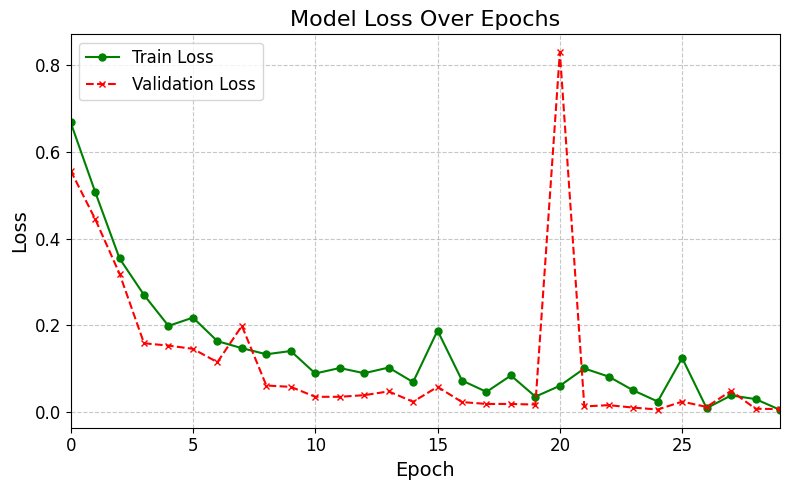

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()


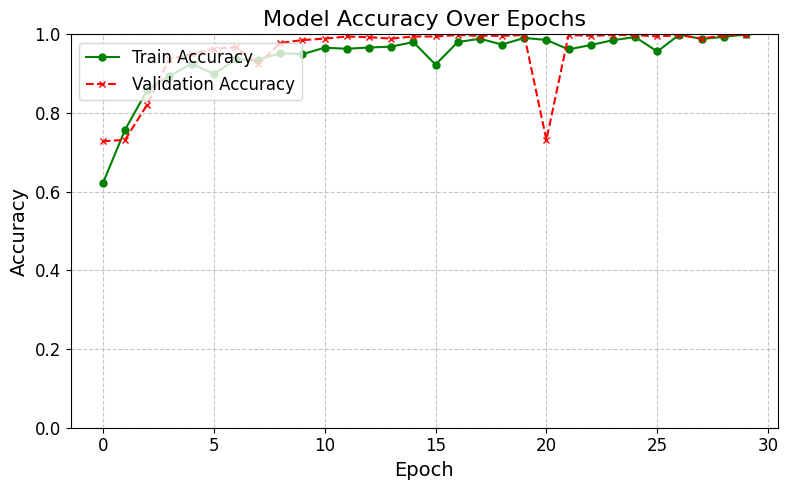

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='green', linestyle='-', marker='o', markersize=5, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Accuracy')

plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.ylim(0, 1)

plt.tight_layout()
plt.show()


# Save Model

In [20]:
model.save("theft_model.h5")  


# Model Evaluation

In [21]:
loss, accuracy = model.evaluate(test_ds)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 1.0000 - loss: 0.0041
Loss: 0.0031742474529892206
Accuracy: 1.0


In [22]:
predictions=model.predict(test_ds)

38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 542ms/step


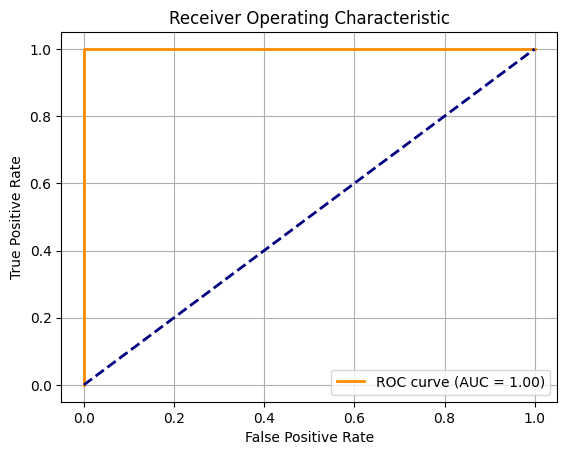

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = predictions.ravel()

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()


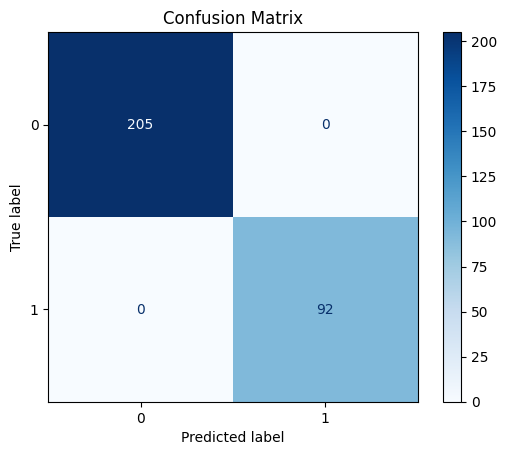

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_labels = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_labels, target_names=["No Theft", "Theft"]))


              precision    recall  f1-score   support

    No Theft       1.00      1.00      1.00       205
       Theft       1.00      1.00      1.00        92

    accuracy                           1.00       297
   macro avg       1.00      1.00      1.00       297
weighted avg       1.00      1.00      1.00       297



1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


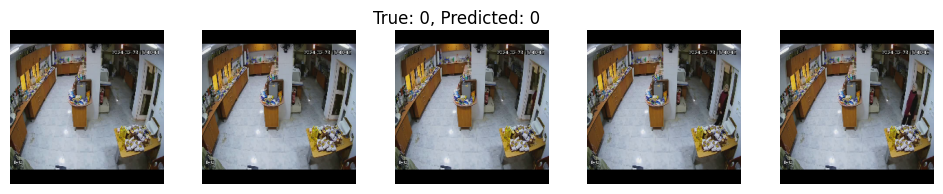

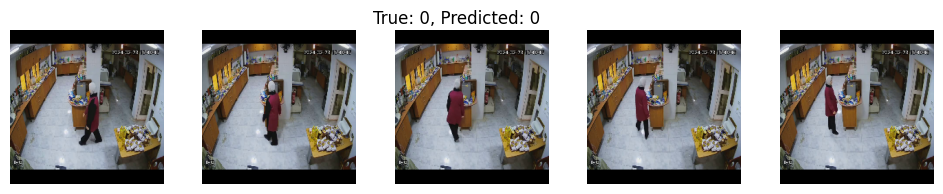

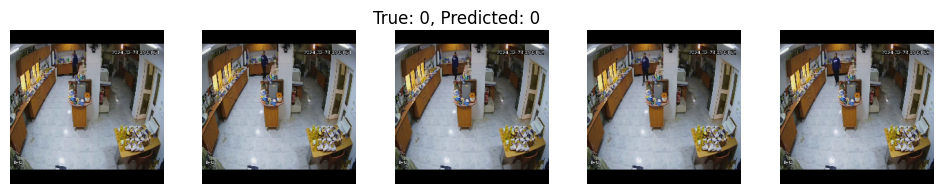

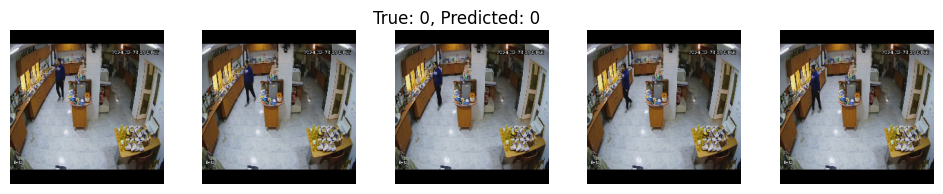

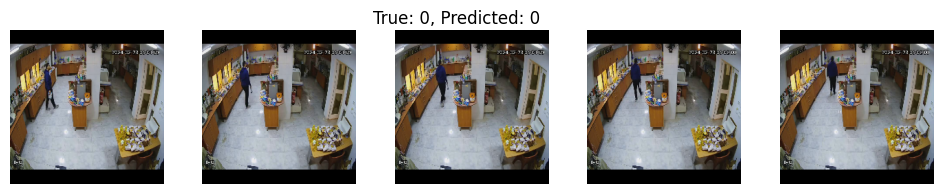

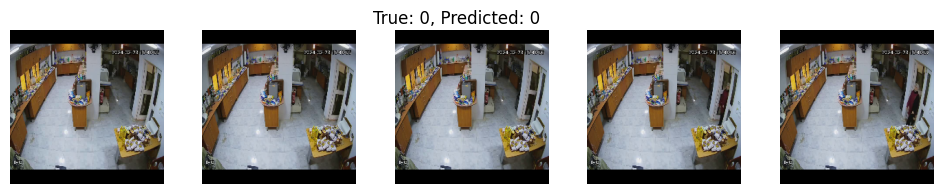

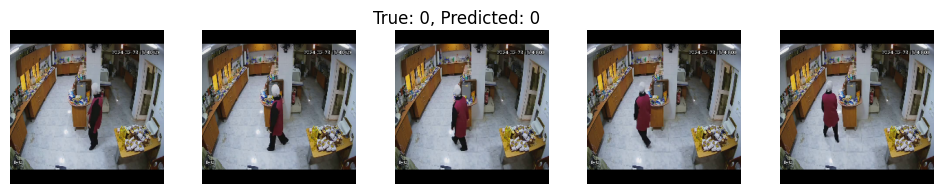

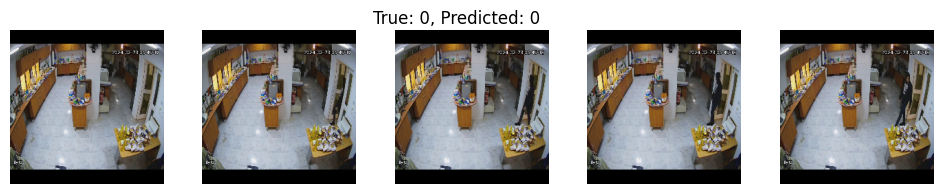

In [26]:
for videos, labels in test_ds.take(1):  
    preds = (model.predict(videos) > 0.5).astype(int)
    for i in range(len(videos)):
        plt.figure(figsize=(12, 2))
        for t in range(min(5, videos.shape[1])):  
            plt.subplot(1, 5, t+1)
            plt.imshow(videos[i][t])
            plt.axis("off")
        plt.suptitle(f"True: {labels[i].numpy()}, Predicted: {preds[i][0]}")
        plt.show()
